> ## ⚠️ Important Lab Disclaimer
> This lab requires API keys (OpenAI, Tavily, OpenWeather) if you want to run the live examples.  
> These keys stay only inside the **temporary Udemy lab workspace** and are **not persisted or shared**, but you should still treat them like any other secret.  
> Use your own discretion when entering keys, and feel free to **revoke or rotate** them after the lab.  
> If you prefer **not** to use real API keys, Copy paste away or download the notebook and run it locally.


This script securely collect API key (`OPENAI_API_KEY`) using `getpass` so your input is hidden.  
It then creates/overwrites a `.env` file and writes each key as `NAME=value` on its own line.  
Finally, it prints **“Saved .env”** when finished.


In [ ]:
from getpass import getpass

names = ["OPENAI_API_KEY"]
with open(".env", "w", encoding="utf-8") as f:
    for n in names:
        f.write(f"{n}={getpass(f'Enter {n}: ').strip()}\n")
print("Saved .env")


This code locates the nearest `.env` file in the current working directory (using `find_dotenv`) and loads its key–value pairs into the environment (using `load_dotenv`).  
It does **not** overwrite any existing environment variables because `override=False`.


In [ ]:
from dotenv import load_dotenv, find_dotenv
env_path = find_dotenv(usecwd=True)
load_dotenv(env_path, override=False)

In [1]:
# Standard library
import os
import re
import json
import uuid
import sqlite3
from collections import Counter
from typing import Any, Dict, List, Literal, Optional

# Third-party
from typing_extensions import TypedDict, Annotated
from IPython.display import Image, display
from pydantic import BaseModel, Field

# LangChain
from langchain_core.tools import tool
from langchain_core.messages import (
    HumanMessage,
    AIMessage,
    SystemMessage,
    ToolMessage,
    RemoveMessage,
    trim_messages,
)
from langchain_core.runnables.config import RunnableConfig
from langchain_openai import ChatOpenAI

# LangGraph
from langgraph.graph import (
    StateGraph,
    START,
    END,
    MessagesState,
    add_messages,
)
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

# Trustcall
from trustcall import create_extractor


In [3]:

chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

This code builds a one-node LangGraph chat agent whose entire conversation state is **persisted in SQLite**.

1. A folder and SQLite file are created (`example.db`), and a connection is opened.
2. `SqliteSaver(conn)` wraps that connection so LangGraph can **store and reload graph checkpoints** (messages, state updates).
3. `memory.setup()` initializes the required tables inside the DB.
4. A simple `chat_turn` node sends the accumulated `MessagesState` to the LLM and returns the new AI reply.
5. The graph is defined with a single node (`turn`) and compiled with `checkpointer=memory`.  
   - This means every invocation automatically **writes the updated state to SQLite**.  
   - On later invocations, using the same thread ID, LangGraph **restores the previous messages from the DB**, giving you persistent chat memory across sessions.


In [4]:
db_path = "state_db/example.db"
os.makedirs(os.path.dirname(db_path), exist_ok=True)
conn = sqlite3.connect(db_path, check_same_thread=False)

memory = SqliteSaver(conn)
memory.setup()  

def chat_turn(state: MessagesState) -> dict:
    reply = chat.invoke(state["messages"])
    return {"messages": [reply]}


builder = StateGraph(MessagesState)
builder.add_node("turn", chat_turn)
builder.add_edge(START, "turn")
builder.add_edge("turn", END)
graph = builder.compile(checkpointer=memory)

A `thread_id` turns on persistent memory:

- `thread_id="todo-thread-1"` stores this conversation in SQLite.
- Invoking the graph saves the messages.
- Future calls with the same `thread_id` automatically reload that history.


In [5]:
cfg = {"configurable": {"thread_id": "todo-thread-1"}}
# Turn 1: normal chat
graph.invoke({"messages": [HumanMessage(content="Help me plan a product launch week.")]}, cfg)

{'messages': [HumanMessage(content='Help me plan a product launch week.', additional_kwargs={}, response_metadata={}, id='0003d5a2-4926-4d8a-9b2b-a3b2db722fbd'),
  AIMessage(content='Day 1: Pre-launch announcement on social media and email newsletter to build anticipation.\n\nDay 2: Host a virtual press conference or media event to officially announce the product and share key details and features.\n\nDay 3: Launch day! Make the product available for purchase on your website and other online platforms. Offer special promotions or discounts to incentivize early sales.\n\nDay 4: Host a live Q&A session on social media to answer any questions about the product and provide additional information.\n\nDay 5: Partner with influencers or brand ambassadors to create buzz and generate excitement around the product launch.\n\nDay 6: Share customer testimonials and reviews on social media to showcase the positive feedback and build credibility.\n\nDay 7: Wrap up the product launch week with a than

With the same `thread_id`, this turn is added to the same SQLite thread:

- The new HumanMessage (“TODO: …”) is appended to the existing history.
- The graph runs and then **saves this updated state** to SQLite.
- The thread now contains both Turn 1 and Turn 2, ready to be reloaded later.


In [6]:
# Turn 2: contains tasks → will extract and save to SQLite
graph.invoke({"messages": [HumanMessage(content="TODO: draft landing page; schedule 3 customer interviews")]}, cfg)

{'messages': [HumanMessage(content='Help me plan a product launch week.', additional_kwargs={}, response_metadata={}, id='0003d5a2-4926-4d8a-9b2b-a3b2db722fbd'),
  AIMessage(content='Day 1: Pre-launch announcement on social media and email newsletter to build anticipation.\n\nDay 2: Host a virtual press conference or media event to officially announce the product and share key details and features.\n\nDay 3: Launch day! Make the product available for purchase on your website and other online platforms. Offer special promotions or discounts to incentivize early sales.\n\nDay 4: Host a live Q&A session on social media to answer any questions about the product and provide additional information.\n\nDay 5: Partner with influencers or brand ambassadors to create buzz and generate excitement around the product launch.\n\nDay 6: Share customer testimonials and reviews on social media to showcase the positive feedback and build credibility.\n\nDay 7: Wrap up the product launch week with a than

Because the same `thread_id` is used, this message becomes the next entry in the same SQLite-backed thread:

- The new task message is appended to the existing conversation.
- The graph produces a reply and **updates the saved checkpoint**.
- The thread now holds Turns 1, 2, and 3 in persistent memory.


In [7]:
# Turn 3: more tasks
graph.invoke({"messages": [HumanMessage(content="Next step: prepare a launch-day checklist and assign owners")]}, cfg)

{'messages': [HumanMessage(content='Help me plan a product launch week.', additional_kwargs={}, response_metadata={}, id='0003d5a2-4926-4d8a-9b2b-a3b2db722fbd'),
  AIMessage(content='Day 1: Pre-launch announcement on social media and email newsletter to build anticipation.\n\nDay 2: Host a virtual press conference or media event to officially announce the product and share key details and features.\n\nDay 3: Launch day! Make the product available for purchase on your website and other online platforms. Offer special promotions or discounts to incentivize early sales.\n\nDay 4: Host a live Q&A session on social media to answer any questions about the product and provide additional information.\n\nDay 5: Partner with influencers or brand ambassadors to create buzz and generate excitement around the product launch.\n\nDay 6: Share customer testimonials and reviews on social media to showcase the positive feedback and build credibility.\n\nDay 7: Wrap up the product launch week with a than

Here you **read back** the saved state from SQLite:

- `s = graph.get_state(cfg)` loads the latest checkpoint for this `thread_id`.
- `s.values["messages"]` gives you the full, restored `messages` history (all turns so far) from persistent memory.


In [8]:
s = graph.get_state(cfg)          # -> StateSnapshot
msgs = s.values["messages"]       # dict-like payload lives in .values
msgs


[HumanMessage(content='Help me plan a product launch week.', additional_kwargs={}, response_metadata={}, id='0003d5a2-4926-4d8a-9b2b-a3b2db722fbd'),
 AIMessage(content='Day 1: Pre-launch announcement on social media and email newsletter to build anticipation.\n\nDay 2: Host a virtual press conference or media event to officially announce the product and share key details and features.\n\nDay 3: Launch day! Make the product available for purchase on your website and other online platforms. Offer special promotions or discounts to incentivize early sales.\n\nDay 4: Host a live Q&A session on social media to answer any questions about the product and provide additional information.\n\nDay 5: Partner with influencers or brand ambassadors to create buzz and generate excitement around the product launch.\n\nDay 6: Share customer testimonials and reviews on social media to showcase the positive feedback and build credibility.\n\nDay 7: Wrap up the product launch week with a thank you message 

This graph combines **short-term chat history** with a **long-term user memo**:

- `store = InMemoryStore()`  
  - Long-term, cross-thread memory per user.  
  - Data is stored under `(TRAVEL_NS, user_id)` with key `MEMO_KEY`, holding a single plain-text `MEMO` (PROFILE + RECENT_TRIPS).

- `checkpointer = MemorySaver()`  
  - Short-term memory for a **single thread** (the rolling `messages` chat history).

- `DEFAULT_MEMO`, `SYSTEM_PROMPT`, and `MEMO_EDITOR`  
  - Define the structure and usage of the long-term `MEMO`.  
  - The LLM **owns and edits** this memo text.

### Nodes and memory flow

- `plan_reply(state, config, store)`  
  - Reads the memo: `store.get((TRAVEL_NS, user_id), MEMO_KEY)` or falls back to `DEFAULT_MEMO`.  
  - Injects this memo into `SYSTEM_PROMPT` and calls the LLM.  
  - Returns the assistant reply as `"messages"` (short-term, per-thread memory via `checkpointer`).

- `write_travel_memory(state, config, store)`  
  - Again loads the current memo from `store`.  
  - Finds the latest `HumanMessage` in `state["messages"]`.  
  - Sends memo + latest user message to `MEMO_EDITOR` prompt.  
  - Writes the updated memo back with `store.put((TRAVEL_NS, user_id), MEMO_KEY, new_memo)`.  
  - This updates **long-term, cross-thread memory** for that user.

### Graph wiring

- Graph order: `START → plan_reply → write_travel_memory → END`.
- `app = g.compile(checkpointer=checkpointer, store=store)`  
  - `checkpointer` keeps **per-thread** conversation history.  
  - `store` keeps a **single evolving memo per user** that survives across threads and sessions.


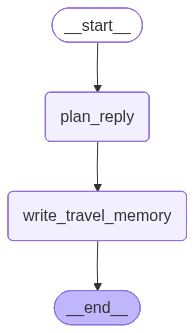

In [9]:
# =============== Long-term store (persists across threads) ===============
store = InMemoryStore()  # per-user, cross-thread memory

# =============== Short-term memory (per thread) ===============
checkpointer = MemorySaver()  # chat history for a single thread

# =============== LLM ===============
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# =============== Simple constants ===============
TRAVEL_NS = "travel"           # namespace: (TRAVEL_NS, user_id)
MEMO_KEY  = "memo"             # one blob: profile + trips

# Initial memo template the very first time we see a user
DEFAULT_MEMO = """PROFILE
- (none yet)

RECENT_TRIPS (most recent first; keep max 3)
- (none)"""

SYSTEM_PROMPT = (
    "You are a friendly travel agent. Personalize using this memo.\n\n"
    "=== MEMO ===\n{memo}\n\n"
    "If the user's message looks like a travel request, answer helpfully and concisely. "
    "Be specific with neighborhoods, sample attractions, and rough budgets when helpful."
)

# The model is the sole owner/editor of the memo. It decides when to add/update.
MEMO_EDITOR = (
    "You maintain a single plain-text MEMO for this user with two sections:\n"
    "PROFILE (bullets, factual, concise)\n"
    "RECENT_TRIPS (most recent first; keep max 3)\n\n"
    "Existing MEMO:\n{memo}\n\n"
    "Latest user message:\n{msg}\n\n"
    "Instructions:\n"
    "- Update PROFILE if there is new info (e.g., preferences, style, rough budget).\n"
    "- If the message clearly implies a new trip intent, append one concise line to RECENT_TRIPS.\n"
    "  Format: \"- City / When / Budget\" (use '(unspecified)' if unclear). Keep only the latest 3 items total.\n"
    "- If nothing new, return the MEMO unchanged.\n\n"
    "Return ONLY the full updated MEMO text (no explanations)."
)

# =============== Nodes ===============
def plan_reply(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    rec = store.get((TRAVEL_NS, user_id), MEMO_KEY)
    memo = rec.value if rec else DEFAULT_MEMO

    sys = SYSTEM_PROMPT.format(memo=memo)
    resp = llm.invoke([SystemMessage(content=sys)] + state["messages"])
    return {"messages": resp}

def write_travel_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    # get current memo
    rec = store.get((TRAVEL_NS, user_id), MEMO_KEY)
    memo = rec.value if rec else DEFAULT_MEMO

    # latest human message (if any)
    latest_human = next((m for m in reversed(state["messages"]) if isinstance(m, HumanMessage)), None)
    if latest_human:
        editor_prompt = MEMO_EDITOR.format(memo=memo, msg=latest_human.content)
        updated = llm.invoke([SystemMessage(content=editor_prompt)])
        new_memo = updated.content.strip()
        # persist the single memo blob
        store.put((TRAVEL_NS, user_id), MEMO_KEY, new_memo)

    return {}

# =============== Graph ===============
g = StateGraph(MessagesState)
g.add_node("plan_reply", plan_reply)
g.add_node("write_travel_memory", write_travel_memory)
g.add_edge(START, "plan_reply")
g.add_edge("plan_reply", "write_travel_memory")
g.add_edge("write_travel_memory", END)

app = g.compile(checkpointer=checkpointer, store=store)

display(Image(app.get_graph().draw_mermaid_png()))


`run()` ties both memory layers together:

- `user_id` loads/updates the **long-term memo** in `store`.
- `thread_id` loads/updates the **short-term chat history** in `checkpointer`.

Streaming the graph with the new `HumanMessage` prints each assistant reply, fully personalized using both memories.


In [10]:
# =============== Demo ===============
def run(user_id: str, thread_id: str, text: str):
    cfg = {"configurable": {"user_id": user_id, "thread_id": thread_id}}
    for chunk in app.stream({"messages": [HumanMessage(content=text)]}, cfg, stream_mode="values"):
        chunk["messages"][-1].pretty_print()

This call runs a conversation for **User A (“alice”)** in **thread t1**:

- Loads Alice’s long-term memo and t1’s short-term chat history.
- Processes her new request (“budget trip to Paris…”).
- Updates both memories and streams the assistant’s personalized reply.

In [11]:
print("\n=== User A (alice) — Thread 1: first trip request ===")
run("alice", "t1", "Hi! Please plan a budget trip to Paris in April, around $1500 total.")
print("********************************************************************************************")


=== User A (alice) — Thread 1: first trip request ===
================================ Human Message =================================

Hi! Please plan a budget trip to Paris in April, around $1500 total.
================================== Ai Message ==================================

Hi there! I'd be happy to help plan your budget trip to Paris in April with a total budget of $1500. Here are some suggestions:

- Accommodation: Look for budget hotels or hostels in neighborhoods like Montmartre or the Latin Quarter.
- Attractions: Visit iconic landmarks like the Eiffel Tower, Louvre Museum, and Notre Dame Cathedral.
- Dining: Enjoy affordable meals at local cafes and bakeries, or try street food markets.
- Transportation: Use public transportation like the metro to get around the city.

Feel free to let me know if you need more specific recommendations or assistance with planning your trip!
********************************************************************************************


Same user (`alice`), same thread (`t1`):

- Reuses Alice’s **existing memo** and the **ongoing t1 chat history**.
- Adds the Boston weekend request on top of the Paris conversation.
- LLM reply + updated memo and history are saved, enriching Alice’s long-term profile.


In [12]:
print("\n=== User A (alice) — Thread 1: second trip request in same convo ===")
run("alice", "t1", "Also, can you plan a quick weekend trip to Boston? Maybe in May.")
print("********************************************************************************************")


=== User A (alice) — Thread 1: second trip request in same convo ===
================================ Human Message =================================

Also, can you plan a quick weekend trip to Boston? Maybe in May.
================================== Ai Message ==================================

It sounds like you're interested in planning a quick weekend trip to Boston in May. I can definitely help with that! 

For a budget-friendly trip to Boston, you can consider staying in neighborhoods like Back Bay or Beacon Hill. Some attractions to check out include the Freedom Trail, Fenway Park, and Quincy Market. 

Feel free to let me know if you need more information or assistance with planning your weekend trip to Boston!
********************************************************************************************


Same user (`alice`), **new thread** (`t2`):

- Long-term memo for Alice is reused, so past Paris/Boston trips still influence suggestions.
- `t2` starts with a fresh chat history but a **remembered profile**, enabling personalized NYC foodie advice.


In [13]:
print("\n=== User A (alice) — Thread 2: new session, still remembers past trips ===")
run("alice", "t2", "Thinking of a foodie trip to New York. Any neighborhoods you recommend?")
print("********************************************************************************************")


=== User A (alice) — Thread 2: new session, still remembers past trips ===
================================ Human Message =================================

Thinking of a foodie trip to New York. Any neighborhoods you recommend?
================================== Ai Message ==================================

Hi there! For a foodie trip to New York, I recommend checking out neighborhoods like Chelsea for its diverse food scene, Greenwich Village for its cozy cafes and restaurants, and Williamsburg in Brooklyn for trendy eateries. Each neighborhood offers a unique culinary experience to explore. Enjoy your foodie adventure!
********************************************************************************************


New user (`bob`), new thread (`t9`):

- Bob gets his **own memo**, separate from Alice’s.
- `t9` has a fresh chat history plus a new long-term profile for Bob.
- Tokyo luxury trip details are stored only in Bob’s memo and thread, keeping user memories isolated.


In [14]:
print("\n=== User B (bob) — Thread 9: isolated user memory ===")
run("bob", "t9", "Plan a luxury trip to Tokyo in September. Budget around $7000.")
print("********************************************************************************************")


=== User B (bob) — Thread 9: isolated user memory ===
================================ Human Message =================================

Plan a luxury trip to Tokyo in September. Budget around $7000.
================================== Ai Message ==================================

Hello! I'd be happy to help plan your luxury trip to Tokyo in September with a budget of around $7000. 

For accommodations, I recommend staying in the upscale neighborhoods of Ginza or Roppongi, known for their luxury hotels and proximity to shopping and dining. 

Be sure to visit iconic attractions such as the historic Senso-ji Temple in Asakusa, the bustling Shibuya Crossing, and the serene Meiji Shrine in Shibuya. 

With your budget, you can also enjoy fine dining experiences at Michelin-starred restaurants, indulge in shopping at high-end boutiques in Omotesando, and even take a day trip to the scenic Hakone region for a relaxing hot spring experience.

Let me know if you need any more specific recommend

This helper lets you **inspect each user’s long-term memo**:

- `get_memo(user_id)` reads `store.get((TRAVEL_NS, user_id), MEMO_KEY)` and returns the saved MEMO text, or `"(no memo found)"` if none exists.
- Printing `get_memo("alice")` and `get_memo("bob")` shows the **separate, persistent profiles and trip histories** stored for each user.


In [15]:
def get_memo(user_id: str) -> str:
    rec = store.get((TRAVEL_NS, user_id), MEMO_KEY)
    return rec.value if rec else "(no memo found)"

print("=== alice ===")
print(get_memo("alice"))
print("\n=== bob ===")
print(get_memo("bob"))


=== alice ===
PROFILE
- Budget traveler
- Interested in budget trips
- Planning a foodie trip to New York
RECENT_TRIPS
- Boston / May / (unspecified)
- New York / (unspecified) / Budget

=== bob ===
PROFILE
- Luxury trip to Tokyo in September with a budget around $7000.

RECENT_TRIPS
- Tokyo / September / $7000


This snippet shows **structured LLM output** using a Pydantic model:

- `class Person(BaseModel): ...` defines a typed schema with `name` and `age`.
- `structured_llm = chat.with_structured_output(Person)` tells the LLM to **always return a `Person` object**.
- `structured_llm.invoke("My name is Alice and I’m 28 years old.")` parses the text into `Person(name="Alice", age=28)`.
- Printing `result` and `result.model_dump_json(indent=2)` shows the **typed object** and its JSON representation.


In [16]:
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

# 1️⃣ Define a simple schema
class Person(BaseModel):
    name: str
    age: int

# 3️⃣ Wrap with structured output
structured_llm = chat.with_structured_output(Person)

# 4️⃣ Call the model
result = structured_llm.invoke("My name is Alice and I’m 28 years old.")

# 5️⃣ Print typed result
print(result)
print(result.model_dump_json(indent=2))


c:\Users\ryanb\coding_projects\easy_langgraph\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1949: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo-0125 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


name='Alice' age=28
{
  "name": "Alice",
  "age": 28
}


This graph adds **structured long-term memory** (profile + trips) on top of chat history.

- `TravelState`  
  - Holds `messages` (short-term chat) and `last_trip` (last parsed trip dict).

- Long-term store vs short-term memory  
  - `store = InMemoryStore()` keeps **per-user profiles and trips** (`profile`, `trips` keys under `NS="travel"`).  
  - `checkpointer = MemorySaver()` keeps **per-thread chat history** in `messages`.

- Helpers  
  - `_get_profile` / `_save_profile` read/write a tiny bullet **profile** per user.  
  - `_get_trips` / `_save_trip` read/write a list of **trip dicts** with generated `id`s.  
  - `_format_recent_trips` returns a short text summary of the last 3 trips.

- Structured trip extraction  
  - `TripRequestModel` is a Pydantic schema describing a trip request.  
  - `extractor = chat.with_structured_output(TripRequestModel, method="function_calling")` parses the latest user message into this structured model (or `is_trip_request=False` if not travel).

- `plan_reply` node  
  - Loads user’s trips from `store`, formats recent trips, injects them into `SYSTEM_REPLY`.  
  - Calls the LLM with system prompt + `state["messages"]` and returns the assistant reply (short-term memory only).

- `write_memory` node  
  1. Finds the latest `HumanMessage` from `state["messages"]`.  
  2. Uses the structured extractor + `SYSTEM_TRIP_EXTRACTOR` to get `trip_model`, then `trip_dict`.  
  3. If `is_trip_request=True`, appends the trip to the user’s `trips` list in `store`.  
  4. Calls a LLM (`SYSTEM_PROFILE_WRITER`) to refresh the user’s bullet **profile** and saves it.  
  5. Returns `{"last_trip": trip_dict}` so the parsed result is visible in the graph state.

- Graph wiring  
  - `START → plan_reply → write_memory → END`.  
  - `app = g.compile(checkpointer=checkpointer, store=store)` means:
    - **Short-term**: each thread keeps rolling chat history via `checkpointer`.  
    - **Long-term**: user profiles + trip history live in `store`, shared across all threads for that user.


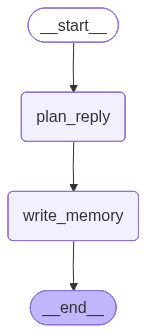

In [17]:
class TravelState(TypedDict, total=False):
    messages: Annotated[list, add_messages]
    last_trip: dict  

class TripRequestModel(BaseModel):
    is_trip_request: bool
    city: str | None = None
    when: str | None = None 
    budget_usd: int | None = None
    notes: str | None = None


NS = "travel"
store = InMemoryStore()        
checkpointer = MemorySaver()   

def _get_profile(store: BaseStore, user_id: str):
    rec = store.get((NS, user_id), "profile")
    return rec.value if rec else {"memory": "- (none yet)"}

def _save_profile(store: BaseStore, user_id: str, text: str):
    store.put((NS, user_id), "profile", {"memory": text})

def _get_trips(store: BaseStore, user_id: str):
    rec = store.get((NS, user_id), "trips")
    return rec.value if rec else []

def _save_trip(store: BaseStore, user_id: str, trip_dict: dict):
    trips = _get_trips(store, user_id)
    trips.append({**trip_dict, "id": str(uuid.uuid4())})
    store.put((NS, user_id), "trips", trips)

def _format_recent_trips(trips: list) -> str:
    if not trips:
        return "- (none)"
    last3 = trips[-3:]
    return "\n".join(
        f"- {t.get('city','?')} / {t.get('when','?')} / ${t.get('budget_usd','?')}  (id={t['id']})"
        for t in last3
    )

SYSTEM_REPLY = (
    "You are a concise, friendly travel agent. Personalize suggestions.\n"
    "Recent trips:\n{recent}\n"
)

SYSTEM_TRIP_EXTRACTOR = (
    "Extract TripRequest fields from the user's latest message.\n"
    "- If NOT a travel request: is_trip_request=false; others null.\n"
    "- If budget mentioned like '$1500' or '1500 USD': return integer 1500 in budget_usd."
)

SYSTEM_PROFILE_WRITER = (
    "Keep a tiny, factual bullet profile for this user. Update only if there's new info.\n"
    "Existing profile:\n{profile}\n\n"
    "User message:\n{msg}\n"
    "Return a short bullet list text."
)

def plan_reply(state: TravelState, config, store: BaseStore):
    """Reply using profile + recent trips + chat history (unchanged behavior)."""
    user_id = config["configurable"]["user_id"]
    recent = _format_recent_trips(_get_trips(store, user_id))
    sys = SYSTEM_REPLY.format(recent=recent)
    resp = chat.invoke([SystemMessage(content=sys)] + state["messages"])
    return {"messages": resp}

def write_memory(state: TravelState, config, store: BaseStore):
    """
    1) Parse latest human message with with_structured_output(..., method='function_calling').
    2) Save trip if is_trip_request=True.
    3) Update profile via a tiny LLM call (kept minimal).
    4) Store parsed dict into state['last_trip'] (for easy printing/peek).
    """
    user_id = config["configurable"]["user_id"]
    latest_human = next((m for m in reversed(state["messages"]) if isinstance(m, HumanMessage)), None)
    content = latest_human.content if latest_human else ""

    # (1) Structured extraction compatible with GPT-3.5
    extractor = chat.with_structured_output(TripRequestModel, method="function_calling")
    trip_model = extractor.invoke([
        SystemMessage(content=SYSTEM_TRIP_EXTRACTOR),
        HumanMessage(content=content),
    ])
    trip_dict = trip_model.model_dump(exclude_none=True)

    # (2) Save trip if applicable
    if trip_dict.get("is_trip_request"):
        _save_trip(store, user_id, trip_dict)

    # (3) Profile update (kept small & consistent with your example)
    existing_profile = _get_profile(store, user_id)["memory"]
    prof = chat.invoke([
        SystemMessage(content=SYSTEM_PROFILE_WRITER.format(profile=existing_profile, msg=content))
    ])
    _save_profile(store, user_id, prof.content.strip())

    # (4) Keep parsed result in state (optional, for demo print)
    return {"last_trip": trip_dict}

g = StateGraph(TravelState)
g.add_node("plan_reply", plan_reply)
g.add_node("write_memory", write_memory)
g.add_edge(START, "plan_reply")
g.add_edge("plan_reply", "write_memory")
g.add_edge("write_memory", END)

app = g.compile(checkpointer=checkpointer, store=store)
display(Image(app.get_graph().draw_mermaid_png()))

This `run` function streams a reply and shows the parsed trip:

- `user_id` loads the user’s long-term profile + trips.  
- `thread_id` loads that thread’s chat history.  
- Streaming prints the assistant’s reply.  
- `app.get_state(...).values["last_trip"]` reveals the **structured trip dict** extracted from the latest message.


In [18]:
# --- DEMO (same Alice/Bob flow) ---
def run(user_id: str, thread_id: str, text: str):
    cfg = {"configurable": {"user_id": user_id, "thread_id": thread_id}}
    for chunk in app.stream({"messages": [HumanMessage(content=text)]}, cfg, stream_mode="values"):
        chunk["messages"][-1].pretty_print()
    # peek parsed structure from state
    st = app.get_state({"configurable": {"thread_id": thread_id}}).values
    print("Parsed TripRequest:", st.get("last_trip"))

First trip request from **Alice** in thread `t1`:

- `run("alice", "t1", "...Paris...$1500.")` streams a reply using a fresh profile + trips for Alice.
- The message is parsed into a **structured TripRequest**, saved to Alice’s long-term trips and exposed as `last_trip` in the thread state.


In [19]:
print("\n=== User A (alice) — Thread 1: first trip request ===")
run("alice", "t1", "Please plan a budget trip to Paris in April, roughly $1500.")


=== User A (alice) — Thread 1: first trip request ===
================================ Human Message =================================

Please plan a budget trip to Paris in April, roughly $1500.
================================== Ai Message ==================================

Hello! A budget-friendly trip to Paris in April for around $1500 is definitely doable. Here are some personalized suggestions for your trip:

1. Flights: Look for affordable flights to Paris from your nearest airport. Consider booking in advance or keeping an eye out for deals on budget airlines.

2. Accommodation: Opt for budget-friendly options such as hostels, Airbnb rentals, or budget hotels in areas like Montmartre or the Latin Quarter.

3. Sightseeing: Take advantage of free or discounted attractions like visiting Notre Dame Cathedral, strolling along the Seine River, exploring the charming streets of Montmartre, and enjoying picnics in parks like Luxembourg Gardens.

4. Dining: Save money by trying out lo

Second trip request from **Alice** in the same thread `t1`:

- Reuses Alice’s existing profile, trips, and chat history.
- The Boston foodie weekend message is parsed into another **TripRequest**, appended to Alice’s stored trips and updated as `last_trip` for this thread.


In [20]:
print("\n=== User A (alice) — Thread 1: second trip request in same convo ===")
run("alice", "t1", "Also, can you plan a quick foodie weekend to Boston in May?")


=== User A (alice) — Thread 1: second trip request in same convo ===
================================ Human Message =================================

Also, can you plan a quick foodie weekend to Boston in May?
================================== Ai Message ==================================

Absolutely! A foodie weekend in Boston sounds like a delicious idea. Here are some personalized suggestions for your culinary adventure:

1. Dining: Indulge in Boston's vibrant food scene by trying out iconic dishes like clam chowder, lobster rolls, and Boston cream pie. Visit local eateries, food trucks, and markets to sample a variety of flavors.

2. Food Tours: Consider joining a food tour to explore different neighborhoods and taste a variety of local specialties. Options include North End's Italian cuisine, seafood in the Seaport District, and diverse offerings in Chinatown.

3. Farmers Markets: Visit farmers markets like Copley Square Farmers Market or Boston Public Market to discover fresh 

New thread `t2` for **Alice**, same user memory:

- Alice’s stored profile + past Paris/Boston trips are reused, even though `t2` has fresh chat history.
- The NYC foodie request is parsed into a new **TripRequest**, added to Alice’s long-term trips and surfaced as `last_trip` for thread `t2`.


In [21]:
print("\n=== User A (alice) — Thread 2: new session, still remembers past trips ===")
run("alice", "t2", "Thinking of a foodie trip to New York. Any neighborhoods you recommend?")


=== User A (alice) — Thread 2: new session, still remembers past trips ===
================================ Human Message =================================

Thinking of a foodie trip to New York. Any neighborhoods you recommend?
================================== Ai Message ==================================

For a foodie trip to New York, I highly recommend exploring the diverse culinary scenes in neighborhoods like Chelsea, Greenwich Village, and Williamsburg. These areas are known for their wide range of restaurants, cafes, and food markets offering everything from gourmet dining to trendy street food. Don't miss out on iconic food spots like Chelsea Market, Eataly, and Smorgasburg for a true taste of New York City! Let me know if you need any more recommendations or assistance with planning your trip.
================================== Ai Message ==================================

For a foodie trip to New York, I highly recommend exploring the diverse culinary scenes in neighborh

New user **Bob** in thread `t9`:

- Bob starts with his own empty profile and trip history (separate from Alice).
- His Tokyo luxury request is parsed into a **TripRequest**, saved only to Bob’s long-term trips and shown as `last_trip` for thread `t9`.


In [22]:
print("\n=== User B (bob) — Thread 9: isolated user memory ===")
run("bob", "t9", "Plan a luxury trip to Tokyo in September. Budget around 7000 USD.")


=== User B (bob) — Thread 9: isolated user memory ===
================================ Human Message =================================

Plan a luxury trip to Tokyo in September. Budget around 7000 USD.
================================== Ai Message ==================================

Hello! A luxury trip to Tokyo in September sounds amazing! With a budget of around 7000 USD, you can enjoy a fantastic experience in one of the most vibrant cities in the world.

Here are some personalized suggestions for your trip:

1. Accommodation: Stay at a luxury hotel in the heart of Tokyo such as The Peninsula Tokyo, Aman Tokyo, or The Ritz-Carlton, Tokyo. These hotels offer top-notch service and stunning views of the city.

2. Dining: Indulge in the world-renowned culinary scene of Tokyo. Make reservations at Michelin-starred restaurants like Sukiyabashi Jiro, Quintessence, or Ryugin for an unforgettable dining experience.

3. Activities: Explore the diverse neighborhoods of Tokyo, from the bustlin

This snippet **inspects long-term memory** for each user:

- `store.get((NS, "alice"), "profile")` / `"trips"` → Alice’s saved profile text and list of parsed trips.
- `store.get((NS, "bob"), "profile")` / `"trips"` → Bob’s separate profile and trips.
- The prints show that each user has their **own persistent profile + trip history**, independent of threads and of each other.


In [23]:
alice_profile = store.get((NS, "alice"), "profile").value
alice_trips   = store.get((NS, "alice"), "trips").value
bob_profile   = store.get((NS, "bob"), "profile").value
bob_trips     = store.get((NS, "bob"), "trips").value

print("\n--- Inspect Long-term Memory ---")
print("Alice profile:", alice_profile)
print("Alice trips:", alice_trips)
print("Bob profile:", bob_profile)
print("Bob trips:", bob_trips)


--- Inspect Long-term Memory ---
Alice profile: {'memory': '- Explore the diverse food scene in neighborhoods like Chinatown, Little Italy, and Greenwich Village\n- Check out food markets like Chelsea Market and Smorgasburg for a variety of culinary options\n- Try affordable eats at food trucks and street vendors throughout the city'}
Alice trips: [{'is_trip_request': True, 'city': 'Paris', 'when': 'April', 'budget_usd': 1500, 'id': '285feeb7-92c5-4cfb-813c-271568a7e42f'}, {'is_trip_request': True, 'city': 'Boston', 'when': 'May', 'id': '43be3e5f-62e4-481a-a97d-890f50e869c2'}, {'is_trip_request': True, 'city': 'New York', 'id': '8442d092-f283-482e-a461-9acee13e76f5'}]
Bob profile: {'memory': '- Luxury trip to Tokyo in September\n- Budget around 7000 USD'}
Bob trips: [{'is_trip_request': True, 'city': 'Tokyo', 'when': 'September', 'budget_usd': 7000, 'id': '4e83fffe-741a-48a8-b984-276f749e55f6'}]


This uses a **trusted tool call** to extract a typed travel request:

- `class TravelRequest(BaseModel): ...` defines the **only allowed schema** (destination, dates, interests).
- `travel_extractor = create_extractor(model, tools=[TravelRequest], tool_choice="TravelRequest")`  
  - Wraps the LLM so it **must respond via the `TravelRequest` tool**, not free-form text.
  - This is the “trust call”: the model is confined to returning a valid `TravelRequest` object.
- `travel_extractor.invoke({...})` runs the extractor with a system message + user message.  
  - `result` is a **structured, validated TravelRequest**
🔗 **Trusted Tool Calls (Function Calling) – GitHub Docs**  
https://github.com/hinthornw/trustcall


In [24]:
class TravelRequest(BaseModel):
    """User travel request with typed fields"""
    destination: str = Field(description="The city or place the user wants to visit")
    start_date: str = Field(description="Trip start date in YYYY-MM-DD format, if mentioned")
    end_date: str = Field(description="Trip end date in YYYY-MM-DD format, if mentioned")
    interests: List[str] = Field(description="List of user’s travel interests, such as museums, food, beaches, or hiking")

conversation = [
    HumanMessage(content="Hi, I’d like to plan a trip to Paris from June 10 to June 15. I love art museums and French food!")
]
model = ChatOpenAI(model="gpt-4o", temperature=0)

travel_extractor = create_extractor(
    model,
    tools=[TravelRequest],
    tool_choice="TravelRequest"
)

system_msg = "Extract the structured travel request from the following user conversation."

result = travel_extractor.invoke({"messages": [SystemMessage(content=system_msg)] + conversation})
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BVUe3KsZlmuKZvWL6zvKgtt3', 'function': {'arguments': '{"destination":"Paris","start_date":"2023-06-10","end_date":"2023-06-15","interests":["art museums","French food"]}', 'name': 'TravelRequest'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 187, 'total_tokens': 222, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e819e3438b', 'id': 'chatcmpl-Ci5AAbMFcDxxzsQn7lxKSogqCWaSC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--4c177baf-07e4-48b7-8b04-b97273c10b32-0', tool_calls=[{'name': 'TravelRequest', 'args': {'destination': 'Paris', 'start_date': '2023-06-10', 'end_date': '2023-06-15', 'i

In [26]:
result["responses"]

[TravelRequest(destination='Paris', start_date='2023-06-10', end_date='2023-06-15', interests=['art museums', 'French food'])]

This graph uses **Trust Call + long-term memory** to capture structured trip data per user.

- `TravelState`  
  - Holds `messages` (per-thread chat history) and `last_trip` (last parsed trip dict).

- Long-term vs short-term memory  
  - `store = InMemoryStore()` keeps per-user **profile** (`"profile"`) and **trips** (`"trips"`) under `NS="travel"`.  
  - `checkpointer = MemorySaver()` keeps per-thread **chat history** in `messages`.

- Trip schema  
  - `TripRequestModel` is a Pydantic model with fields like `is_trip_request`, `city`, `when`, `budget_usd`, `notes`.

- Trusted extractor (Trust Call)  
  - `trip_extractor = create_extractor(llm, tools=[TripRequestModel], tool_choice="TripRequestModel")`  
    - Forces the model to respond **only via the `TripRequestModel` tool**, returning a validated object instead of free text.

- Helper functions  
  - `_get_profile` / `_save_profile` → read/write a tiny bullet **profile** per user.  
  - `_get_trips` / `_save_trip` → read/write list of trip dicts, adding a UUID `id`.  
  - `_format_recent_trips` → formats the last 3 trips as text.

### Nodes

- `plan_reply(state, config, store)`  
  - Looks up the user’s trips from `store`, formats recent trips via `_format_recent_trips`.  
  - Builds `SYSTEM_REPLY` with those trips and calls `llm.invoke` with system + `state["messages"]`.  
  - Returns the assistant reply in `"messages"` (short-term memory only).

- `write_memory(state, config, store)`  
  1. Finds the latest `HumanMessage` in `state["messages"]`.  
  2. Calls `trip_extractor.invoke({"messages": [SystemMessage(SYSTEM_TRIP_EXTRACTOR), HumanMessage(content)]})`.  
     - Trust Call returns a dict with `"responses"`, containing one `TripRequestModel` instance (or equivalent dict).  
     - Code reads `responses[0]`, normalizes it to `trip_dict` (dropping `None` values).  
  3. If `trip_dict["is_trip_request"]` is true, `_save_trip` appends it to the user’s `"trips"` in `store`.  
  4. Updates the user’s `"profile"` using `SYSTEM_PROFILE_WRITER` and saves via `_save_profile`.  
  5. Returns `{"last_trip": trip_dict}` so the parsed data is visible in `TravelState`.

### Graph

- Edges: `START → plan_reply → write_memory → END`.  
- `app = g.compile(checkpointer=checkpointer, store=store)`  
  - `checkpointer` → rolling chat per thread.  
  - `store` → persistent profile + structured trips per user, driven by the trusted `TripRequestModel` extractor.


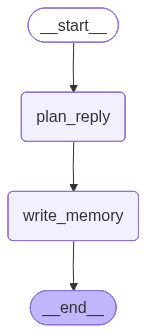

In [27]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)


class TravelState(TypedDict, total=False):
    messages: Annotated[list, add_messages]
    last_trip: dict 


class TripRequestModel(BaseModel):
    """Model to extract trip request information."""
    is_trip_request: bool = Field(
        description="True if the message asks for a trip plan, travel ideas, or vacation details."
    )
    city: Optional[str] = Field(description="Destination city or place, if mentioned.")
    when: Optional[str] = Field(description="Trip time frame (month, dates, or season).")
    budget_usd: Optional[int] = Field(description="Budget in USD if specified.")
    notes: Optional[str] = Field(description="Additional context like purpose or preferences.")

NS = "travel"
store = InMemoryStore()
checkpointer = MemorySaver()

def _get_profile(store: BaseStore, user_id: str):
    rec = store.get((NS, user_id), "profile")
    return rec.value if rec else {"memory": "- (none yet)"}

def _save_profile(store: BaseStore, user_id: str, text: str):
    store.put((NS, user_id), "profile", {"memory": text})

def _get_trips(store: BaseStore, user_id: str):
    rec = store.get((NS, user_id), "trips")
    return rec.value if rec else []

def _save_trip(store: BaseStore, user_id: str, trip_dict: dict):
    trips = _get_trips(store, user_id)
    trips.append({**trip_dict, "id": str(uuid.uuid4())})
    store.put((NS, user_id), "trips", trips)

def _format_recent_trips(trips: list) -> str:
    if not trips:
        return "- (none)"
    last3 = trips[-3:]
    return "\n".join(
        f"- {t.get('city','?')} / {t.get('when','?')} / ${t.get('budget_usd','?')}  (id={t['id']})"
        for t in last3
    )

SYSTEM_REPLY = (
    "You are a concise, friendly travel agent. Personalize suggestions.\n"
    "Recent trips:\n{recent}\n"
)

SYSTEM_TRIP_EXTRACTOR = (
    "You are a travel request extractor.\n"
    "Your task is to fill all fields of TripRequestModel based on the user's message.\n"
    "- If the message is about planning a trip, set is_trip_request=true and extract city, when, budget_usd, and notes.\n"
    "- If not, set is_trip_request=false and leave other fields null.\n"
    "Be concise and output valid JSON only."
)

SYSTEM_PROFILE_WRITER = (
    "Keep a tiny, factual bullet profile for this user. Update only if there's new info.\n"
    "Existing profile:\n{profile}\n\n"
    "User message:\n{msg}\n"
    "Return a short bullet list text."
)

trip_extractor = create_extractor(
    llm,
    tools=[TripRequestModel],
    tool_choice="TripRequestModel",
)

# --- Nodes ---
def plan_reply(state: TravelState, config, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    recent = _format_recent_trips(_get_trips(store, user_id))
    sys = SYSTEM_REPLY.format(recent=recent)
    resp = llm.invoke([SystemMessage(content=sys)] + state["messages"])
    return {"messages": resp}

def write_memory(state: TravelState, config, store: BaseStore):
    """
    1) Extract trip fields via TrustCall (read from result['responses'][0]).
    2) Save trip if is_trip_request=True.
    3) Update profile.
    4) Keep parsed dict in state['last_trip'].
    """
    user_id = config["configurable"]["user_id"]
    latest_human = next((m for m in reversed(state["messages"]) if isinstance(m, HumanMessage)), None)
    content = latest_human.content if latest_human else ""

    # (1) Extraction (IMPORTANT: read responses[0])
    tc_result = trip_extractor.invoke({
        "messages": [
            SystemMessage(content=SYSTEM_TRIP_EXTRACTOR),
            HumanMessage(content=content)
        ]
    })

    # Debug: show tool calls detected by TrustCall & raw responses
    try:
        last_msg = tc_result.get("messages", [])[-1]
        print("🔧 tool_calls:", getattr(last_msg, "tool_calls", None))
    except Exception:
        pass
    print("raw responses:", tc_result.get("responses"))

    responses = tc_result.get("responses") or []
    if not responses:
        trip_dict = {}
    else:
        first = responses[0]
        if hasattr(first, "model_dump"):
            trip_dict = first.model_dump(exclude_none=True)
        elif isinstance(first, dict):
            # normalize: drop None values
            trip_dict = {k: v for k, v in first.items() if v is not None}
        else:
            # best effort fallback
            try:
                trip_dict = dict(first)
            except Exception:
                trip_dict = {}

    print(f"extracted trip_dict for {user_id}:", trip_dict)

    # (2) Save trip if applicable
    if trip_dict.get("is_trip_request"):
        _save_trip(store, user_id, trip_dict)

    # (3) Profile update
    existing_profile = _get_profile(store, user_id)["memory"]
    prof = llm.invoke([
        SystemMessage(content=SYSTEM_PROFILE_WRITER.format(profile=existing_profile, msg=content))
    ])
    _save_profile(store, user_id, prof.content.strip())

    # (4) keep in state
    return {"last_trip": trip_dict}


g = StateGraph(TravelState)
g.add_node("plan_reply", plan_reply)
g.add_node("write_memory", write_memory)
g.add_edge(START, "plan_reply")
g.add_edge("plan_reply", "write_memory")
g.add_edge("write_memory", END)

app = g.compile(checkpointer=checkpointer, store=store)
display(Image(app.get_graph().draw_mermaid_png()))

This `run` helper ties together Trust Call, chat, and memory:

- `user_id` → loads/updates that user’s **profile + trips** in `store`.
- `thread_id` → loads/updates that thread’s **chat history** via `checkpointer`.
- `app.stream(..., cfg, ...)` prints the assistant’s reply.
- `app.get_state(...).values["last_trip"]` shows the **structured TripRequestModel dict** produced by the trusted extractor for this message.


In [28]:
def run(user_id: str, thread_id: str, text: str):
    cfg = {"configurable": {"user_id": user_id, "thread_id": thread_id}}
    for chunk in app.stream({"messages": [HumanMessage(content=text)]}, cfg, stream_mode="values"):
        chunk["messages"][-1].pretty_print()
    st = app.get_state({"configurable": {"thread_id": thread_id}}).values
    print("Parsed TripRequest:", st.get("last_trip"))

First trusted extraction for **Alice** in thread `t1`:

- `run("alice", "t1", "...Paris in April, roughly $1500.")` streams a reply using fresh profile + trips for Alice.
- Trust Call converts this into a **TripRequestModel dict** (city, when, budget, etc.).
- That dict is saved to Alice’s long-term trips and exposed as `last_trip` in the thread state.


In [29]:
print("\n=== User A (alice) — Thread 1: first trip request ===")
run("alice", "t1", "Please plan a budget trip to Paris in April, roughly $1500.")


=== User A (alice) — Thread 1: first trip request ===
================================ Human Message =================================

Please plan a budget trip to Paris in April, roughly $1500.
================================== Ai Message ==================================

Absolutely, a budget-friendly trip to Paris in April sounds wonderful! Here's a plan to make the most of your $1500 budget:

**Flights:**
- Look for round-trip flights from budget airlines or use flight comparison websites. Booking in advance can help you find deals around $500-$600.

**Accommodation:**
- Consider staying in a hostel or budget hotel. Areas like Montmartre or the Latin Quarter offer affordable options. Aim for around $60-$80 per night for a 5-night stay, totaling approximately $300-$400.

**Transportation:**
- Purchase a Paris Visite pass for unlimited travel on public transport. A 5-day pass costs about $40.

**Food:**
- Enjoy delicious yet affordable meals by dining at local bistros, bakeries, 

Second trusted extraction for **Alice** in thread `t1`:

- Reuses Alice’s existing profile, trips, and chat history.
- Trust Call turns the Boston foodie weekend message into another **TripRequestModel dict**.
- That dict is appended to Alice’s stored trips and becomes the new `last_trip` for `t1`.


In [30]:
print("\n=== User A (alice) — Thread 1: second trip request in same convo ===")
run("alice", "t1", "Also, can you plan a quick foodie weekend to Boston in May?")


=== User A (alice) — Thread 1: second trip request in same convo ===
================================ Human Message =================================

Also, can you plan a quick foodie weekend to Boston in May?
================================== Ai Message ==================================

Absolutely, a foodie weekend in Boston sounds delicious! Here's a plan to savor the city's culinary delights:

**Accommodation:**
- Look for a centrally located budget hotel or Airbnb in neighborhoods like Back Bay or the North End. Expect to spend around $150-$200 per night for a 2-night stay, totaling $300-$400.

**Transportation:**
- Use the MBTA for getting around. A weekend pass costs about $12.

**Foodie Highlights:**

**Day 1:**
- **Breakfast:** Start your day with a classic New England breakfast at The Friendly Toast in Back Bay.
- **Lunch:** Head to Quincy Market for a variety of food stalls. Try the famous clam chowder or lobster roll.
- **Dinner:** Enjoy Italian cuisine in the North End

New thread `t2` for **Alice**, same trusted memory:

- Alice’s profile and prior Paris/Boston trips are reused from `store`, even though `t2` is a fresh chat thread.
- Trust Call converts the NYC foodie message into a new **TripRequestModel dict**.
- That dict is added to Alice’s long-term trips and set as `last_trip` for thread `t2`.


In [31]:
print("\n=== User A (alice) — Thread 2: new session, still remembers past trips ===")
run("alice", "t2", "Thinking of a foodie trip to New York. Any neighborhoods you recommend?")


=== User A (alice) — Thread 2: new session, still remembers past trips ===
================================ Human Message =================================

Thinking of a foodie trip to New York. Any neighborhoods you recommend?
================================== Ai Message ==================================

New York is a fantastic choice for a foodie adventure! Since you enjoyed Paris, you'll love the diverse culinary scene in NYC. Here are a few neighborhoods to explore:

1. **Greenwich Village**: Known for its charming streets and a mix of classic and trendy eateries. Don't miss the chance to try some authentic Italian food here.

2. **Williamsburg, Brooklyn**: Offers a hip vibe with a variety of artisanal food spots, from gourmet pizza to innovative brunch spots.

3. **Chinatown**: Perfect for exploring a wide range of Asian cuisines, from dim sum to hand-pulled noodles.

4. **East Village**: Known for its eclectic mix of restaurants, offering everything from ramen to vegan delig

First trusted extraction for **Bob** in thread `t9`:

- Bob starts with his own empty profile and trip list, separate from Alice’s.
- Trust Call turns the Tokyo luxury request into a **TripRequestModel dict**.
- That dict is saved only to Bob’s long-term trips and exposed as `last_trip` for `t9`.


In [32]:
print("\n=== User B (bob) — Thread 9: isolated user memory ===")
run("bob", "t9", "Plan a luxury trip to Tokyo in September. Budget around 7000 USD.")


=== User B (bob) — Thread 9: isolated user memory ===
================================ Human Message =================================

Plan a luxury trip to Tokyo in September. Budget around 7000 USD.
================================== Ai Message ==================================

That sounds like an exciting trip! Here's a luxurious itinerary for your Tokyo adventure in September:

**Accommodation:**
- **Aman Tokyo**: Stay at this stunning hotel known for its minimalist design and exceptional service. Enjoy panoramic views of the city from your spacious suite.

**Day 1: Arrival and Relaxation**
- **Private Airport Transfer**: Arrive in style with a private transfer to your hotel.
- **Dinner at Narisawa**: Experience innovative Japanese cuisine at this two-Michelin-starred restaurant.

**Day 2: Cultural Exploration**
- **Private Guided Tour**: Visit the historic Asakusa district and the iconic Senso-ji Temple. 
- **Lunch at Sukiyabashi Jiro**: Savor sushi at this world-renowned, thr

This snippet safely inspects **long-term memory** for each user:

- `safe_get(ns, key, field)`  
  - Wraps `store.get((ns, key), field)` and returns `rec.value` or `{}` if nothing is stored.

- `alice_profile`, `alice_trips`  
  - Alice’s saved profile and list of trusted TripRequest dicts.

- `bob_profile`, `bob_trips`  
  - Bob’s separate profile and trips.

- The prints show each user’s **independent, persistent memory**, falling back to `"- (none)"` when empty.


In [33]:
def safe_get(ns: str, key: str, field: str):
    rec = store.get((ns, key), field)
    return rec.value if rec else {}

alice_profile = safe_get(NS, "alice", "profile")
alice_trips   = safe_get(NS, "alice", "trips")
bob_profile   = safe_get(NS, "bob", "profile")
bob_trips     = safe_get(NS, "bob", "trips")

print("\n--- Inspect Long-term Memory ---")
print("Alice profile:", alice_profile or "- (none)")
print("Alice trips:", alice_trips or "- (none)")
print("Bob profile:", bob_profile or "- (none)")
print("Bob trips:", bob_trips or "- (none)")


--- Inspect Long-term Memory ---
Alice profile: {'memory': '- Consider exploring neighborhoods like Greenwich Village, Williamsburg, and the Lower East Side for diverse food options.\n- Check out Chelsea Market and Smorgasburg for a variety of local specialties.\n- Visit Little Italy and Chinatown for authentic international cuisine experiences.'}
Alice trips: [{'is_trip_request': True, 'city': 'Paris', 'when': 'April', 'budget_usd': 1500, 'notes': 'Budget trip', 'id': 'd8e4e4c5-de27-41bd-a53c-fa81f24a957a'}, {'is_trip_request': True, 'city': 'Boston', 'when': 'May', 'notes': 'foodie weekend', 'id': '1cd2be8c-aae7-4f84-bf3a-c92cce34770a'}, {'is_trip_request': True, 'city': 'New York', 'notes': 'Foodie trip, looking for neighborhood recommendations', 'id': '052ed9a1-3977-4017-8223-0002d494cf81'}]
Bob profile: {'memory': '- Destination: Tokyo, Japan\n- Travel Month: September\n- Budget: Approximately 7000 USD\n- Trip Type: Luxury'}
Bob trips: [{'is_trip_request': True, 'city': 'Tokyo', 


---

### Recap

You explored **four core patterns** for building travel agents with LangGraph:

---

#### 1. Short-Term Memory (SQLite Checkpointer)

* Used `SqliteSaver` + `thread_id` to persist **per-thread chat history**.
* Each thread resumes where it left off.
* `graph.get_state()` returns the stored messages.

---

#### 2. Dual Memory: Long-Term Store + Short-Term Checkpointer

* `MemorySaver` → per-thread rolling chat history.
* `InMemoryStore` → **per-user long-term memory** (profile, memo, recent trips).
* Multiple threads share user memory; users remain isolated.

---

#### 3. Structured Output (Pydantic Extraction)

* Used `TripRequestModel` to turn raw text into **typed objects**.
* `with_structured_output()` guaranteed well-formed fields like:

  * destination
  * dates
  * budget
  * notes
* Enabled clean downstream logic (save trip, update profile, store `last_trip`).

---

#### 4. Trust Call (Guaranteed Tool-Based Extraction)

* `create_extractor(... tool_choice="TripRequestModel")` forced the model to return **only** a validated Pydantic object.
* No free text; extraction becomes deterministic and safe.
* Output appears in `result["responses"][0]`.

---

##### Multi-User, Multi-Thread Behavior

* Each user has **separate long-term memory**.
* Each thread has **separate short-term chat**, but shared user memory.
* Alice’s data never mixes with Bob’s.

---

##### You built agents that:


**remember users long-term, maintain per-thread chat history, extract structured trip data with guarantees, and update memory safely using LangGraph.**

---

